In [1]:
#Making Dependencies

!pip install ninja
!pip install flask-ngrok

!git clone https://github.com/BeingHomosapien/ACGPN
%cd ACGPN

import gdown
import numpy as np
from PIL import Image
import IPython
import os
import sys

!mkdir Data_preprocessing/test_color
!mkdir Data_preprocessing/test_colormask
!mkdir Data_preprocessing/test_edge
!mkdir Data_preprocessing/test_img
!mkdir Data_preprocessing/test_label
!mkdir Data_preprocessing/test_mask
!mkdir Data_preprocessing/test_pose
!mkdir inputs
!mkdir inputs/img
!mkdir inputs/cloth

#Downloading weights for pose
%cd pose
!gdown --id 1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
%cd ..

!git clone https://github.com/BeingHomosapien/Self-Correction-Human-Parsing-for-ACGPN
!git clone https://github.com/priyanshu-shubham/U-2-Net.git

#Downloading weights for segmentation mask generation
url = 'https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH'
output = 'lip_final.pth'
gdown.download(url, output, quiet=False)


# Here we are working with the popular U-Net that is used for image segmentation and mask formation

%cd U-2-Net
!mkdir saved_models
!mkdir saved_models/u2net
!mkdir saved_models/u2netp
!gdown --id 1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy -O saved_models/u2netp/u2netp.pth
!gdown --id 1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ -O saved_models/u2net/u2net.pth

%cd ..


#Downloading weights
!mkdir checkpoints
gdown.download('https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx',output='checkpoints/ACGPN_checkpoints.zip', quiet=False)
%cd checkpoints
!unzip ACGPN_checkpoints
%cd ..



     |████████████████████████████████| 112kB 11.0MB/s 
Cloning into 'ACGPN'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (72/72), done.
remote: Total 78 (delta 2), reused 78 (delta 2), pack-reused 0
Unpacking objects: 100% (78/78), done.
/content/ACGPN
/content/ACGPN/pose
Downloading...
From: https://drive.google.com/uc?id=1hOHMFHEjhoJuLEQY0Ndurn5hfiA9mwko
To: /content/ACGPN/pose/pose_iter_440000.caffemodel
209MB [00:03, 56.1MB/s]
/content/ACGPN
Cloning into 'Self-Correction-Human-Parsing-for-ACGPN'...
remote: Enumerating objects: 637, done.
remote: Counting objects: 100% (637/637), done.
remote: Compressing objects: 100% (525/525), done.
remote: Total 637 (delta 105), reused 637 (delta 105), pack-reused 0
Receiving objects: 100% (637/637), 3.65 MiB | 17.41 MiB/s, done.
Resolving deltas: 100% (105/105), done.
Cloning into 'U-2-Net'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/8

Downloading...
From: https://drive.google.com/uc?id=1k4dllHpu0bdx38J7H28rVVLpU-kOHmnH
To: /content/ACGPN/lip_final.pth
267MB [00:04, 62.4MB/s]


/content/ACGPN/U-2-Net
Downloading...
From: https://drive.google.com/uc?id=1rbSTGKAE-MTxBYHd-51l2hMOQPT_7EPy
To: /content/ACGPN/U-2-Net/saved_models/u2netp/u2netp.pth
4.68MB [00:00, 24.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ao1ovG1Qtx4b7EoskHXmi2E9rp5CHLcZ
To: /content/ACGPN/U-2-Net/saved_models/u2net/u2net.pth
176MB [00:02, 81.3MB/s]
/content/ACGPN


Downloading...
From: https://drive.google.com/uc?id=1UWT6esQIU_d4tUm8cjxDKMhB8joQbrFx
To: /content/ACGPN/checkpoints/ACGPN_checkpoints.zip
524MB [00:04, 105MB/s]


/content/ACGPN/checkpoints
Archive:  ACGPN_checkpoints.zip
   creating: label2city/
  inflating: label2city/latest_net_G.pth  
  inflating: label2city/latest_net_G1.pth  
  inflating: label2city/latest_net_G2.pth  
  inflating: label2city/latest_net_U.pth  
  inflating: label2city/opt.txt      
/content/ACGPN


In [2]:
#Importing required modules

from predict_pose import generate_pose_keypoints

%cd U-2-Net
import u2net_load
import u2net_run

u2net = u2net_load.model(model_name = 'u2netp')
%cd ..

!mkdir magic

/content/ACGPN/U-2-Net
...load U2NEP---4.7 MB
/content/ACGPN


In [3]:
#Functions for flask app

import requests

def download(url,filepath):
    file_ = requests.get(url, stream=True).raw
    image = Image.open(file_)
    image.save(filepath)


def infer(imagePath,clothPath):
    print("Infering for:")
    print(f"Person Image:{imagePath}")
    print(f"Cloth Image:{clothPath}")
    cloth_name = '000001_1.png'
    cloth_path = clothPath
    cloth = Image.open(cloth_path)
    cloth = cloth.resize((192, 256), Image.BICUBIC).convert('RGB')
    cloth.save(os.path.join('Data_preprocessing/test_color', cloth_name))

    u2net_run.infer(u2net, 'Data_preprocessing/test_color', 'Data_preprocessing/test_edge')


    import time

    start_time = time.time()
    img_name = '000001_0.png'
    img_path = os.path.join('inputs/img', sorted(os.listdir('inputs/img'))[0])
    img = Image.open(img_path)
    img = img.resize((192,256), Image.BICUBIC)

    img_path = os.path.join('Data_preprocessing/test_img', img_name)
    img.save(img_path)
    resize_time = time.time()
    print('Resized image in {}s'.format(resize_time-start_time))

    !python3 Self-Correction-Human-Parsing-for-ACGPN/simple_extractor.py --dataset 'lip' --model-restore 'lip_final.pth' --input-dir 'Data_preprocessing/test_img' --output-dir 'Data_preprocessing/test_label'
    parse_time = time.time()
    print('Parsing generated in {}s'.format(parse_time-resize_time))

    pose_path = os.path.join('Data_preprocessing/test_pose', img_name.replace('.png', '_keypoints.json'))
    generate_pose_keypoints(img_path, pose_path)
    pose_time = time.time()
    print('Pose map generated in {}s'.format(pose_time-parse_time))


    !rm -rf Data_preprocessing/test_pairs.txt
    with open('Data_preprocessing/test_pairs.txt','w') as f:
        f.write('000001_0.png 000001_1.png')
    
    !python test.py

    output_grid = np.concatenate([np.array(Image.open('Data_preprocessing/test_img/000001_0.png')),
                np.array(Image.open('Data_preprocessing/test_color/000001_1.png')),
                np.array(Image.open('results/test/try-on/000001_0.png'))], axis=1)
    image_grid = Image.fromarray(output_grid)
    return image_grid

Infering for:
Person Image:/content/ACGPN/inputs/img/000003_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000248_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.010193109512329102s
100% 1/1 [00:00<00:00,  3.39it/s]
Parsing generated in 5.275018215179443s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 3.82681941986084s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 

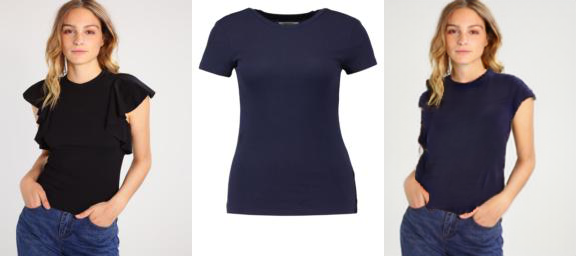

In [ ]:
#Testing
infer("/content/ACGPN/inputs/img/000003_0.jpg","/content/ACGPN/inputs/cloth/000248_1.jpg")

In [4]:
!pip install flask-cors

In [4]:
!pwd

/content


In [6]:
#Flask App

from flask_ngrok import run_with_ngrok
from flask import (
    Flask,
    render_template,
    redirect,
    url_for,
    jsonify,
    request,
    session,
    send_file,
    make_response,
)
import base64
from flask_cors import CORS
import io

app = Flask(__name__)
CORS(app)
run_with_ngrok(app)  # starts ngrok when the app is run


@app.route("/",methods=["GET",])
def home():
    return "<h1>Running Flask on Google Colab!</h1>"

@app.route('/uploader/<typ>', methods = ['GET', 'POST'])
def upload_file(typ):
   if request.method == 'POST':
      f = request.files['file']
      f.save(("/content/ACGPN/inputs/"+typ+"/"+f.filename))
      return 'file uploaded successfully'

@app.route('/infer/',methods = ['POST',])
def inferImage():
    if request.method=="POST":
        clothFileName=request.form.get('cloth').split('/')[-1].split('\\')[-1]
        personFileName=request.form.get('person').split('/')[-1].split('\\')[-1]
        magic=infer('/content/ACGPN/inputs/img/'+personFileName,'/content/ACGPN/inputs/cloth/'+clothFileName)
        magic.save('./magic/magic.png')

        with open("./magic/magic.png", "rb") as f:
            image_binary = f.read()

            response = make_response(base64.b64encode(image_binary))
            response.headers.set('Content-Type', 'image/png')
            response.headers.set('Content-Disposition', 'attachment', filename='magic.png')
            return response

app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://f335919eb4a9.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [02/Mar/2021 17:07:49] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:07:56] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:07:56] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000240_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011399507522583008s
100% 1/1 [00:00<00:00,  8.64it/s]
Parsing generated in 5.589810609817505s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0175645351409912s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:08:11] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:12:14] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:12:21] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:12:22] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000005_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000370_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011705160140991211s
100% 1/1 [00:00<00:00,  8.71it/s]
Parsing generated in 5.5805792808532715s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0270483493804932s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:12:37] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:13:50] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:13:50] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:13:51] "POST /uploader/img HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000228_1.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000370_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.01095890998840332s


127.0.0.1 - - [02/Mar/2021 17:13:56] "GET / HTTP/1.1" 200 -


  0% 0/1 [00:00<?, ?it/s]Infering for:
Person Image:/content/ACGPN/inputs/img/000228_1.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000370_1.jpg
100% 1/1 [00:00<00:00,  8.50it/s]
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.016660213470458984s
Parsing generated in 5.815620422363281s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.1251392364501953s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global

127.0.0.1 - - [02/Mar/2021 17:14:08] "POST /infer/ HTTP/1.1" 200 -


?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global: 0
no_flip: False
norm: instance
ntest: inf
onnx: None
output_nc: 3
phase: test
resize_or_crop: scale_width
results_dir: ./results/
serial_batches: True
tf_log: False
use_dropout: False
use_encoded_image: False
verbose: False
which_epoch: latest
-------------- End ----------------
CustomDatasetDataLoader
dataset [AlignedDataset] was created
Data_preprocessing/test_label label
Data_preprocessing/test_img img
Data_preprocessing/tes

127.0.0.1 - - [02/Mar/2021 17:14:15] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:14:47] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:15:00] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:15:01] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000378_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011932611465454102s
100% 1/1 [00:00<00:00,  9.19it/s]
Parsing generated in 5.6920459270477295s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0130062103271484s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:15:15] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:16:09] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000378_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011758804321289062s
100% 1/1 [00:00<00:00,  9.05it/s]
Parsing generated in 5.688861608505249s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0188512802124023s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:16:23] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:16:50] "GET / HTTP/1.1" 200 -
[2021-03-02 17:16:50,670] ERROR in app: Exception on /infer/ [POST]
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 2447, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1952, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.7/dist-packages/flask_cors/extension.py", line 165, in wrapped_function
    return cors_after_request(app.make_response(f(*args, **kwargs)))
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1821, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.7/dist-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.7/dist-packages/flask/app.py", line 1950, in full_dispatch_reque

Infering for:
Person Image:/content/ACGPN/inputs/img/000023_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000284_1.jpg


127.0.0.1 - - [02/Mar/2021 17:17:07] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:17:16] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:17:18] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000023_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000312_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011012792587280273s
100% 1/1 [00:00<00:00,  9.16it/s]
Parsing generated in 5.5850090980529785s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0059924125671387s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:17:32] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:19:06] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:19:13] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:19:14] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000013_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000248_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.012419462203979492s
100% 1/1 [00:00<00:00,  9.16it/s]
Parsing generated in 5.6841044425964355s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.011096715927124s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:19:29] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:20:41] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:20:50] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:20:51] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000005_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000303_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.012207269668579102s
100% 1/1 [00:00<00:00,  8.87it/s]
Parsing generated in 5.588414192199707s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0053181648254395s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:21:05] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:22:59] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:23:06] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:23:06] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000240_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.012309074401855469s
100% 1/1 [00:00<00:00,  9.45it/s]
Parsing generated in 5.6920342445373535s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.017871618270874s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:23:21] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:24:46] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:24:53] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:24:54] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000030_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000378_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011355161666870117s
100% 1/1 [00:00<00:00,  8.69it/s]
Parsing generated in 5.682889699935913s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0136687755584717s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:25:08] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:30:17] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:30:22] "POST /uploader/cloth HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:30:24] "GET / HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000370_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.012694835662841797s
100% 1/1 [00:00<00:00,  8.63it/s]
Parsing generated in 5.7948832511901855s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0132346153259277s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:30:38] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:35:14] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:35:20] "POST /uploader/cloth HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000284_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.014519453048706055s
100% 1/1 [00:00<00:00,  9.00it/s]
Parsing generated in 5.689077377319336s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.015202283859253s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global:

127.0.0.1 - - [02/Mar/2021 17:35:35] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:36:57] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:37:08] "POST /uploader/cloth HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000005_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000248_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011940479278564453s
100% 1/1 [00:00<00:00,  9.41it/s]
Parsing generated in 5.5874083042144775s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0191411972045898s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:37:23] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:39:09] "POST /uploader/img HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:39:17] "POST /uploader/cloth HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000303_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011479616165161133s
100% 1/1 [00:00<00:00,  8.93it/s]
Parsing generated in 5.582101345062256s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0222969055175781s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:39:33] "POST /infer/ HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000004_0.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000303_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.011540651321411133s
100% 1/1 [00:00<00:00,  9.45it/s]
Parsing generated in 5.586763858795166s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 1.0200161933898926s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_global

127.0.0.1 - - [02/Mar/2021 17:40:26] "POST /uploader/img HTTP/1.1" 200 -


latest_net_U.pth
latest_net_G1.pth
latest_net_G2.pth
latest_net_G.pth
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:279: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3385: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Saving 000001_0.png


127.0.0.1 - - [02/Mar/2021 17:40:29] "POST /infer/ HTTP/1.1" 200 -
127.0.0.1 - - [02/Mar/2021 17:40:30] "POST /uploader/cloth HTTP/1.1" 200 -


Infering for:
Person Image:/content/ACGPN/inputs/img/000228_1.jpg
Cloth Image:/content/ACGPN/inputs/cloth/000248_1.jpg
Generating mask for: 000001_1.png
Saving output at Data_preprocessing/test_edge/000001_1.png
Resized image in 0.012730121612548828s
100% 1/1 [00:00<00:00,  8.99it/s]
Parsing generated in 5.5854270458221436s
File saved at Data_preprocessing/test_pose/000001_0_keypoints.json
Pose map generated in 0.9975442886352539s
?
------------ Options -------------
aspect_ratio: 1.0
batchSize: 1
checkpoints_dir: ./checkpoints
cluster_path: features_clustered_010.npy
continue_train: False
data_type: 32
datapairs: test_pairs.txt
dataroot: Data_preprocessing/
display_winsize: 512
engine: None
export_onnx: None
fineSize: 512
gpu_ids: [0]
how_many: 1000
input_nc: 3
isTrain: False
label_nc: 20
loadSize: 512
max_dataset_size: inf
model: pix2pixHD
nThreads: 1
n_blocks_global: 4
n_blocks_local: 3
n_downsample_global: 4
n_local_enhancers: 1
name: label2city
netG: global
ngf: 64
niter_fix_globa

127.0.0.1 - - [02/Mar/2021 17:40:45] "POST /infer/ HTTP/1.1" 200 -
